In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy.io

In [2]:
!ls -ltrh /mnt/c/Users/ignacio.ibarra/Dropbox/workspace/affreg/data/PbmDataHom6_norm.mat

-rwxrwxrwx 1 rio rio 103M Dec 24  2013 /mnt/c/Users/ignacio.ibarra/Dropbox/workspace/affreg/data/PbmDataHom6_norm.mat


In [3]:
mat = scipy.io.loadmat('/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/affreg/data/PbmDataHom6_norm.mat')

NameError: name 'scipy' is not defined

In [4]:
mat.keys()

NameError: name 'mat' is not defined

In [5]:
for k in mat['PbmData']:
    print(len(k))

NameError: name 'mat' is not defined

In [6]:
data = mat['PbmData'][0]
symbols = data[0][0][0][0][0]
seqs_dbd = data[0][0][0][0][1]
seqs_full = data[0][0][0][0][2]

To align paste into the ebi server and/or run ete toolkit locally

In [218]:
# https://www.ebi.ac.uk/Tools/services/rest/clustalo

In [8]:
for i, s in enumerate(seqs_dbd[:10]):
    print('>' + symbols[i][0][0] + '_' + str(i))
    print(str(s[0][0]))
    # break

>Alx3_0
RRNRTTFSTFQLEELEKVFQKTHYPDVYAREQLALRTDLTEARVQVWFQNRRAKWRK
>Alx4_1
RRNRTTFTSYQLEELEKVFQKTHYPDVYAREQLAMRTDLTEARVQVWFQNRRAKWRK
>Arx_2
RRYRTTFTSYQLEELERAFQKTHYPDVFTREELAMRLDLTEARVQVWFQNRRAKWRK
>Bapx1_3
KRSRAAFSHAQVFELERRFNHQRYLSGPERADLAASLKLTETQVKIWFQNRRYKTKR
>Barhl1_4
RKARTAFTDHQLAQLERSFERQKYLSVQDRMELAASLNLTDTQVKTWYQNRRTKWKR
>Barhl2_5
RKARTAFSDHQLNQLERSFERQKYLSVQDRMDLAAALNLTDTQVKTWYQNRRTKWKR
>Barx1_6
RRSRTVFTELQLMGLEKRFEKQKYLSTPDRIDLAESLGLSQLQVKTWYQNRRMKWKK
>Barx2_7
RRSRTIFTELQLMGLEKKFQKQKYLSTPDRLDLAQSLGLTQLQVKTWYQNRRMKWKK
>Bsx_8
RKARTVFSDSQLSGLEKRFEIQRYLSTPERVELATALSLSETQVKTWFQNRRMKHKK
>Cart1_9
RRHRTTFTSLQLEELEKVFQKTHYPDVYVREQLALRTELTEARVQVWFQNRRAKWRK


In [3]:
p = 'output_clustal_pbmdata.txt'

In [4]:
ali_by_k = {}
for r in open(p).readlines():
    c = r.split('\t')[0].strip().split(' ')
    # print(c, len(c))
    s, seq = c[0], c[-1]
    if not '_' in s:
        continue
    # print(s, seq)
    ali_by_k[s] = seq if not s in ali_by_k else ali_by_k[s] + seq
        

In [5]:
for s in ali_by_k:
    print(s, ali_by_k[s])
    break

Irx2_83 ---PAYRKNATRDATATLKAWLNEHRKNPYP----TKGEKIMLAII---------------------TKMTLTQVSTWFANARRRLKK


In [6]:
import multibind as mb

In [37]:
tf_data = pd.read_csv('../../data/cisbp_mm/TF_Information_all_motifs_plus.txt', sep='\t')

In [214]:
tf_data['TF_Status'].value_counts()

I    90718
D     1213
N      575
Name: TF_Status, dtype: int64

In [55]:
import numpy as np

,0,1,2,3,4,5,6,7,8
Pos,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
A,0.268445,0.200643,0.315755,0.782420,0.101611,0.671433,0.308060,0.231796,0.271804
C,0.240482,0.235457,0.080236,0.011733,0.743341,0.112103,0.244764,0.229489,0.243491
G,0.255353,0.276312,0.258518,0.091139,0.043867,0.066647,0.116780,0.363528,0.248410
T,0.235720,0.287588,0.345491,0.114708,0.111181,0.149817,0.330396,0.175187,0.236295


In [140]:
seqs = [ali_by_k[k] for k in ali_by_k]

In [150]:
annot = pd.DataFrame([[aa for aa in s] for s in seqs])
hm = pd.DataFrame([[0.0 for aa in s] for s in seqs])

In [151]:
import seaborn as sns

In [187]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 10
rcParams['figure.dpi'] = 100

In [201]:
import scipy.cluster.hierarchy as hc
def get_dism(words):
    entries = []
    for i, a in enumerate(words):
        for j, b in enumerate(words):
            if j < i:
                continue
            d = dist(a, b)
            entries.append([i, j, d])
            if i != j:
                entries.append([j, i, d])

    df_dism = pd.DataFrame(entries, columns=['i', 'j', 'd'])
    df_dism = df_dism.pivot('i', 'j', 'd')
    return df_dism

def dist(a, b):
    assert len(a) == len(b)
    return len(a) - sum(ai == bi for ai, bi in zip(a, b))

def plot_alignment(seqs, show=True, out_basename=None, cluster=False):
    linkage = None
    if show:
        dism = get_dism(seqs)
        # print(dism)
        linkage = hc.linkage(scipy.spatial.distance.squareform(dism), method='average')
        sns.clustermap(dism, row_linkage=linkage, col_linkage=linkage, figsize=[5, 5])
                       # xticklabels=None, yticklabels=None)

        if out_basename is not None:
            plt.savefig(out_basename + '_words_2d.png')
            plt.close()
            
    df_remaining = pd.DataFrame([[letter for letter in w] for w in seqs])
    df_remaining.index = ['w.%i' % i for i in range(df_remaining.shape[0])]
    df_remaining.columns = ['c.%i' % i for i in range(df_remaining.shape[1])]
    import numpy as np
    df_mask = pd.DataFrame(index=df_remaining.index)
    
    print(df_remaining.head())
    df_mask['challenge'] = 'white'
    df_colors = df_remaining.copy()
    letters = pd.Series(df_remaining.values.flatten()).value_counts().sort_values()
    cmap = {k: idx for idx, k in enumerate(letters.sample(letters.shape[0], random_state=500).index)}
    for c in df_colors:
        df_colors[c] = df_remaining[c].map(cmap).astype(int)

    if show:
        df_dism = pd.DataFrame([[i, j, dist(a, b)] for i, a in enumerate(seqs) for j, b in enumerate(seqs)], columns=['i', 'j', 'd'])
        df_dism = df_dism.pivot('i', 'j', 'd')
        
        linkage = hc.linkage(scipy.spatial.distance.squareform(df_dism), method='average') if cluster else None
        g = sns.clustermap(df_colors, row_linkage=linkage if cluster else None, col_cluster=False,
                           row_cluster=linkage is not None, annot=df_remaining if df_remaining.shape[0] < 50 else None,
                       fmt='', cmap=sns.color_palette("Paired"), mask=df_remaining=='-',
                           figsize=[4, 6], row_colors=df_mask) #  xticklabels=None, yticklabels=None)
        g.ax_heatmap.tick_params(left=False, bottom=False)

        if out_basename is not None:
            plt.savefig(out_basename + '_words_1d.png')
            plt.close()
    
    if not show:
        plt.close()
    if show and out_basename is not None:
        plt.show()

    c.0 c.1 c.2 c.3 c.4 c.5 c.6 c.7 c.8 c.9  ... c.78 c.79 c.80 c.81 c.82  \
w.0   -   -   -   P   A   Y   R   K   N   A  ...    F    A    N    A    R   
w.1   -   -   -   P   A   Y   R   K   N   A  ...    F    A    N    A    R   
w.2   -   -   -   -   -   -   P   K   N   A  ...    F    A    N    A    R   
w.3   -   -   -   -   -   -   P   K   N   A  ...    F    A    N    A    R   
w.4   -   -   -   -   -   -   R   K   N   A  ...    F    A    N    A    R   

    c.83 c.84 c.85 c.86 c.87  
w.0    R    R    L    K    K  
w.1    R    R    L    K    K  
w.2    R    R    L    K    K  
w.3    R    R    L    K    K  
w.4    R    R    L    K    K  

[5 rows x 88 columns]


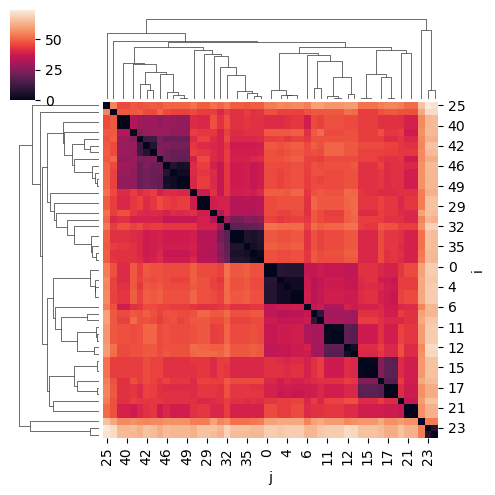

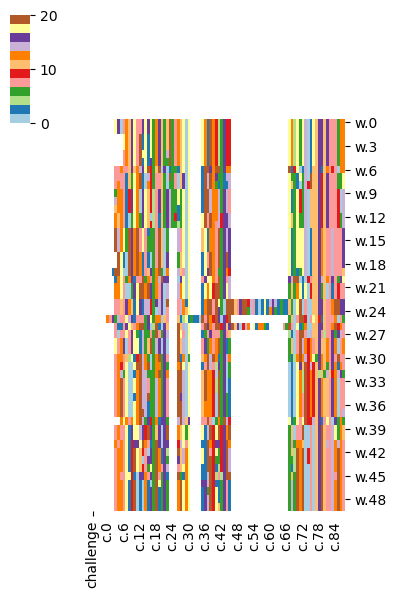

In [202]:
plot_alignment(seqs[:50])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 3, 1
rcParams['figure.dpi'] = 30

In [204]:
seq, pwm = [], []
for symbol in list(ali_by_k.keys()):
    # print(s)
    s = ali_by_k[symbol]
    print(s)
    encoded = mb.tl.onehot_protein(s) 
    sel = tf_data[(tf_data['TF_Name'] == symbol.split('_')[0])]
    sel = sel[sel['TF_Status'] == 'D']
    # print(sel.shape)
    m_id = sel.head(1)['Motif_ID'].values[0] if sel.shape[0] > 0 else np.nan
    # print(s, encoded.shape, sel.shape, m_id)
    
#     pwm_path = '../../data/cisbp_mm/pwms_all_motifs/%s.txt' % m_id
#     seq.append(encoded)
#     pwm.append(pd.read_csv(pwm_path, sep='\t').T.tail(4) if not pd.isnull(m_id) else m_id)
#     rcParams['figure.figsize'] = 3, 1
#     print(symbol)
#     print(s)
    
#     if len(pwm) < 10:
#         if not pd.isnull(m_id):
#             crp_logo = logomaker.Logo(pwm[-1].T, shade_below=0.5, fade_below=0.5)
#             # break
#             plt.show()
#         else:
#             print('nan')

---PAYRKNATRDATATLKAWLNEHRKNPYP----TKGEKIMLAII---------------------TKMTLTQVSTWFANARRRLKK
---PAYRKNATRDATATLKAWLNEHRKNPYP----TKGEKIMLAII---------------------TKMTLTQVSTWFANARRRLKK
------PKNATRESTSTLKAWLNEHRKNPYP----TKGEKIMLAII---------------------TKMTLTQVSTWFANARRRLKK
------PKNATRESTSTLKAWLNEHRKNPYP----TKGEKIMLAII---------------------TKMTLTQVSTWFANARRRLKK
------RKNATRETTSTLKAWLQEHRKNPYP----TKGEKIMLAII---------------------TKMTLTQVSTWFANARRRLKK
------RKNATRESTSALKAWLHEHRKNPYP----TKGEKIMLAII---------------------TKMTLTQVSTWFANARRRLKK
---RRKRRNFNKQATEILNEYFYSHLSNPYP----SEEAKEELAKK---------------------CGITVSQVSNWFGNKRIRYKK
---RRRRGNLPKESVQILRDWLYEHRYNAYP----SEQEKALLSQQ---------------------THLSTLQVCNWFINARRRLLP
---RKRRGNLPKESVKILRDWLYLHRYNAYP----SEQEKLSLSGQ---------------------TNLSVLQICNWFINARRRLLP
---HKKRGIFPKVATNIMRAWLFQHLTHPYP----SEEQKKQLAQD---------------------TGLTILQVNNWFINARRRIVQ
---QKKRGIFPKVATNIMRAWLFQHLTHPYP----SEEQKKQLAQD---------------------TGLTILQVNNWFINARRRIVQ
---NKKRGIFPKVATNIMRAW

In [128]:
x = seq
y = pwm

AttributeError: 'list' object has no attribute 'shape'

In [134]:
import pickle
pickle.dump([x, y], open('../../data/example_homeo_PbmData.pkl', 'wb'))

In [215]:
x, y = pickle.load(open('../../data/example_homeo_PbmData.pkl', 'rb'))

In [217]:
pd.DataFrame(x[0])

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [211]:
len(y)

178